In [1]:
from mutators import *
import seaborn as sns
import matplotlib.pyplot as plt
from encoders import shape_count, SHAPES
from tqdm import tqdm
from matplotlib.pyplot import figure
import time
import optuna
import pickle
from Bio import pairwise2
from IPython.display import clear_output

In [2]:
class freezable_defaultdict(dict):
    def __init__(self, default_factory, *args, **kwargs):
        self.frozen = False
        self.default_factory = default_factory
        super(freezable_defaultdict, self).__init__(*args, **kwargs)

    def __missing__(self, key):
        if self.frozen:
            return self.default_factory()
        else:
            self[key] = value = self.default_factory()
            return value

    def freeze(self):
        self.frozen = True

In [3]:
file_sizes = {'mutant_nfs.txt' :8360, 
        'mutant_fnc.txt': 437, 
        'mutant_rfam.txt': 6753,
        'mutant_shuffled.txt': 852241}

def extract_features(fname, filter=None, with_shapes=True):
    # folded_mutants = read_fold(f'/Users/koushulramjattun/Downloads/FindAllRNA/FindAllRNA/mutants/{fname}')
    folded_mutants = read_fold(fname)

    ref = defaultdict(list)
    families = defaultdict()
    shapes = defaultdict(dict)

    # pbar = tqdm(total = file_sizes[fname], desc=fname)
    # pbar = tqdm(total = 437)
    
    old_label = ''

    for fm in folded_mutants: 
        tag = ''
        seq_label = '_'.join(fm.label.split('_')[:2])
        
        if old_label != seq_label:
            old_label = seq_label
            # pbar.update()
            
        
        if seq_label not in families:
            families[seq_label] = defaultdict(list)
        
        
        if 'deletion' in fm.label:  
            tag = 'del'
            
        elif 'substitution':
            tag = 'sub_'+fm.label.split('_substitution_')[1]
            
            
        families[seq_label][tag].append(fm.mfe)
       
    
    # pbar.close()

        
    return families, shapes, ref

In [123]:
variations = {
    'nfs' : {},
    'fnc' : {},
    'rfam': {},
    'mrna': {},
    'shuffled': {}
}

possible_transitions = ['A|C', 'A|G', 'A|T', 'C|A', 'C|G', 'C|T', 'G|A', 'G|C', 'G|T', 'T|A', 'T|C', 'T|G']

for ps in possible_transitions:
    for rnatype in variations.keys():
        variations[rnatype][ps] = []
        variations[rnatype]['lengths'] = []    

In [127]:
pbar = tqdm(totla = 32655)
for rnatype in variations.keys():
    pbar.set_description(rnatype)
    a, b, c = extract_features(f'./folded/mutated_{rnatype}.txt', with_shapes=False)
    for _, X in a.items():    
        pbar.update()
        variations[rnatype]['lengths'].append(len(X['del'])+1)
        for ps in possible_transitions:
            label = f'sub_{ps}'
            if len(X[label]) == 0:
                variations[rnatype][ps].append(0)
            else:
                variations[rnatype][ps].append((np.var(X[label]))/len(X[label]))
pbar.close()

In [139]:
from collections import Counter

In [141]:
Counter(np.digitize(variations['rfam']['lengths'], bins=np.arange(40, 250, 10)))

Counter({8: 195,
         6: 465,
         9: 81,
         5: 1205,
         7: 168,
         4: 3885,
         3: 131,
         1: 30,
         2: 76,
         10: 66,
         12: 36,
         21: 23,
         18: 36,
         13: 36,
         14: 56,
         15: 110,
         16: 41,
         19: 13,
         17: 41,
         20: 27,
         11: 33})

In [143]:
nfs_counter = Counter(np.digitize(variations['nfs']['lengths'], bins=np.arange(40, 250, 10)))

In [181]:
def match(dist1, dist2, bw):
    target_dist = Counter(np.digitize(dist1, bins=np.arange(40, 250, bw)))
    
    matched_indices = []
    for bin_number, n in target_dist.items():
        indices = np.where(np.digitize(dist2, bins=np.arange(40, 250, bw)) == bin_number)[0]
        for i in np.random.choice(indices, n, replace=True):
            matched_indices.append(i)
            
    return matched_indices

In [179]:
resampled = []
for bin_number, n in Counter(np.digitize(variations['rfam']['lengths'], bins=np.arange(40, 250, 5))).items():
    for i in select_indices(bin_number, n):
        resampled.append(i)

In [ ]:
variations['nfs']['']

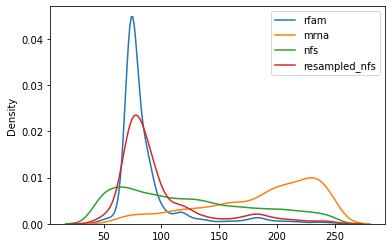

In [180]:
sns.kdeplot(variations['rfam']['lengths'], label = 'rfam')
sns.kdeplot(variations['mrna']['lengths'], label = 'mrna')
sns.kdeplot(variations['nfs']['lengths'], label = 'nfs')
sns.kdeplot(np.array(variations['nfs']['lengths'])[np.unique(resampled)], label = 'resampled_nfs')
plt.legend()
plt.show()


In [9]:
# import json
# with open('variations.json', 'w') as f:
#     f.write(json.dumps(variations, indent=4, sort_keys=True))

In [114]:
a, b, c = extract_features(f'./folded/mutated_shuffled.txt', with_shapes=False)

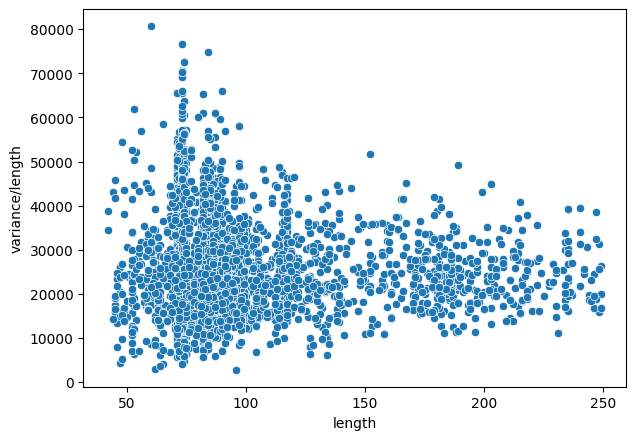

In [119]:
figure(figsize=(7, 5), dpi=100)

df_ = pd.DataFrame([(np.var(y['sub_C|T'])*len(y['del'])**2, len(y['del'])) for x, y in a.items()], columns=['variance/length', 'length'])
sns.scatterplot(data=df_, x='length', y='variance/length')
plt.show()

In [6]:
elife = pd.read_csv('./bacteria_transcript_error_rates.csv')
data = elife[elife['Species ']=='E. coli'].sort_values(by='Conditional_error_rate', ascending=False)
subs = data.Substitutions.replace({'>', '|'}).values

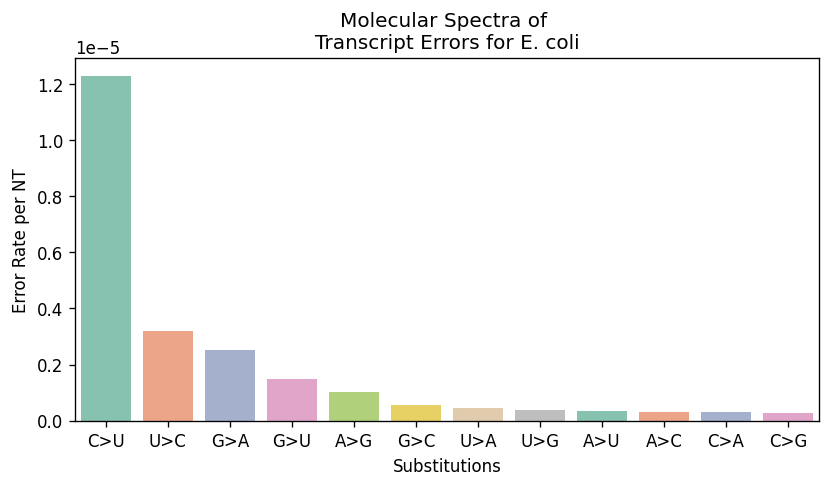

In [10]:
figure(figsize=(8, 4), dpi=120)
sns.barplot(data = data[['Substitutions', 'Conditional_error_rate']], x='Substitutions', y='Conditional_error_rate', palette='Set2', alpha=0.85)
plt.ylabel('Error Rate per NT')
plt.title("Molecular Spectra of \nTranscript Errors for E. coli")
plt.show()

In [11]:
# import json
# with open('variations.json', 'r') as f:
#     variations = json.load(f)

In [95]:
def prep_data():
    df_rfam = pd.DataFrame(variations['rfam'])
    df_nfs = pd.DataFrame(variations['nfs'])
    df_fnc = pd.DataFrame(variations['fnc'])
    df_shuffled = pd.DataFrame(variations['shuffled'])
    df_mrna = pd.DataFrame(variations['mrna'])

    df_rfam.columns = [c.replace('T', 'U').replace('|', '>') for c in df_rfam.columns]
    df_nfs.columns = [c.replace('T', 'U').replace('|', '>') for c in df_nfs.columns]
    df_mrna.columns = [c.replace('T', 'U').replace('|', '>') for c in df_mrna.columns]
    df_shuffled.columns = [c.replace('T', 'U').replace('|', '>') for c in df_shuffled.columns]
    
    return df_rfam, df_nfs, df_shuffled, df_mrna

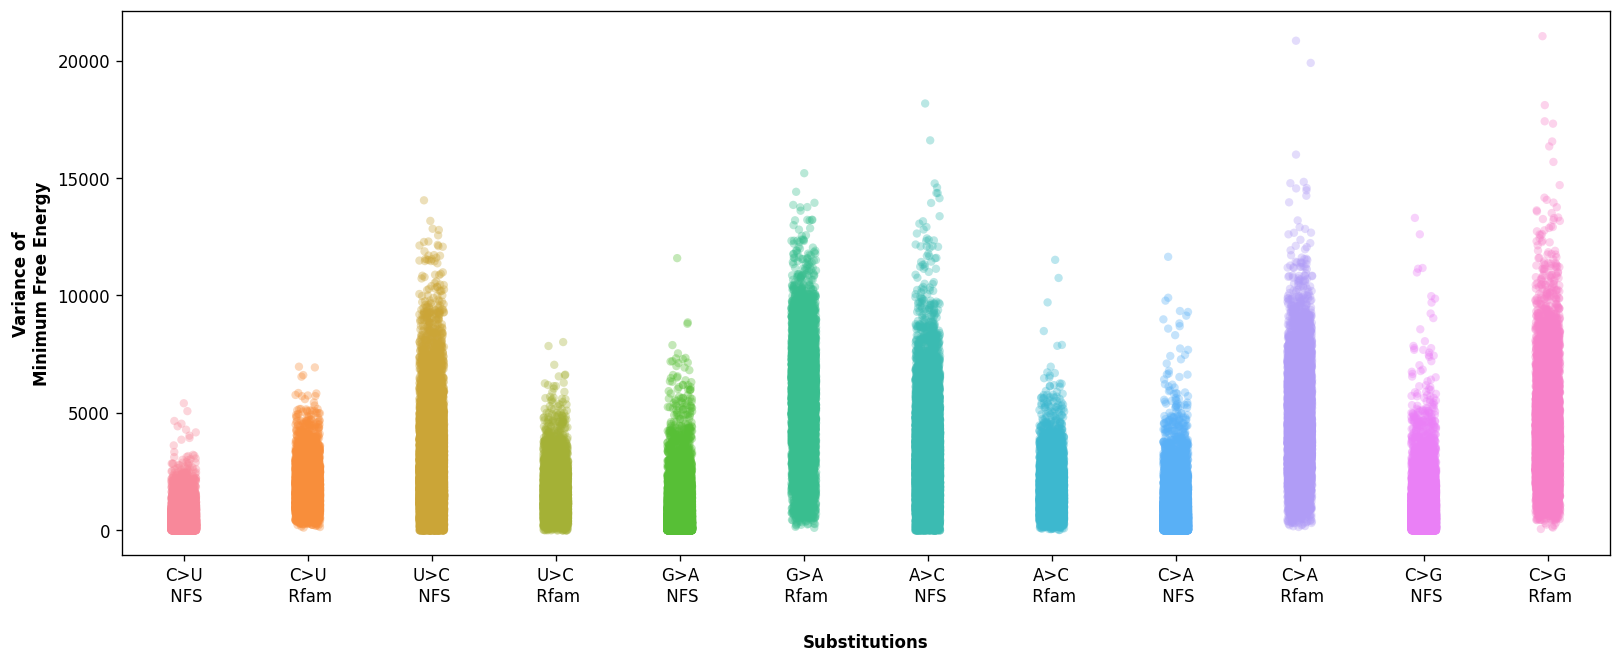

In [96]:
figure(figsize=(16, 6), dpi=120)

df_rfam, df_nfs, df_shuffled, df_mrna = prep_data()

df_rfam = df_rfam[subs[[0,1,2,-3,-2,-1]]]
df_nfs = df_nfs[subs[[0,1,2,-3,-2,-1]]]


df_rfam.columns = [c.replace('T', 'U').replace('|', '>')+ '\n Rfam' for c in df_rfam.columns]
df_nfs.columns = [c.replace('T', 'U').replace('|', '>')+ '\n NFS' for c in df_nfs.columns]

# plt.axhline(0, c='red', alpha = 0.3)

mixed_df = pd.concat([df_rfam, df_nfs])

mixed_df = mixed_df[[
    'C>U\n NFS', 'C>U\n Rfam', 
    'U>C\n NFS', 'U>C\n Rfam',
    'G>A\n NFS', 'G>A\n Rfam',
    'A>C\n NFS', 'A>C\n Rfam', 
    'C>A\n NFS', 'C>A\n Rfam', 
    'C>G\n NFS', 'C>G\n Rfam', 
]]

# mixed_df = mixed_df[sorted(pd.concat([df_rfam, df_nfs]).columns)]
# sns.violinplot(data=mixed_df)
sns.stripplot(data=mixed_df, alpha=0.35, jitter=True)



plt.ylabel('Variance of\nMinimum Free Energy', fontweight='bold', fontsize=10)
plt.xlabel('\nSubstitutions', fontweight='bold', fontsize=10)

# plt.savefig('subs_fnc.png', dpi=180)
plt.show()

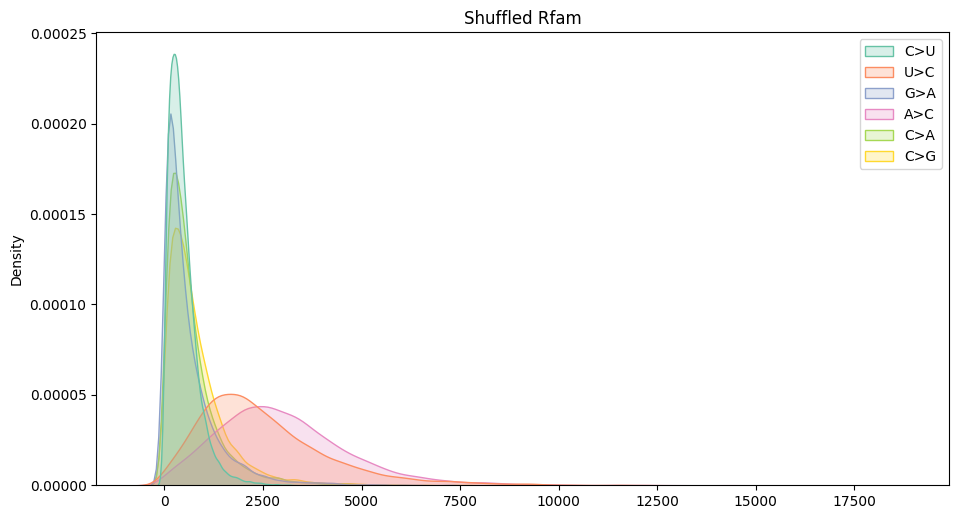

In [121]:
df_rfam, df_nfs, df_shuffled, df_mrna = prep_data()

df_rfam = df_rfam[subs]
df_nfs = df_nfs[subs]
df_shuffled = df_nfs[subs]
df_mrna = df_mrna[subs]

# figure(figsize=(11, 6), dpi=100)
# fig = sns.kdeplot(data=df_rfam, fill=True, palette='Set2')
# plt.title('Rfam')
# # plt.xlim(-0.5, 1.5)
# plt.show()

# figure(figsize=(11, 6), dpi=100)
# fig = sns.kdeplot(data=df_nfs, fill=True, palette='Set2')
# plt.title('Non Feature Spaces')
# # plt.xlim(-0.5, 1.5)
# plt.show()

figure(figsize=(11, 6), dpi=100)
fig = sns.kdeplot(data=df_shuffled[subs[[0,1,2,-3,-2,-1]]], fill=True, palette='Set2')
plt.title('Shuffled Rfam')
# plt.xlim(-0.5, 1.5)
plt.show()

# figure(figsize=(11, 6), dpi=100)
# fig = sns.kdeplot(data=df_mrna, fill=True, palette='Set2')
# plt.title('mRNA')
# plt.xlim(-0.5, 1.5)
# plt.show()

In [56]:
import json
with open('dump.json', 'w') as f:
    f.write(json.dumps(dict(a['seq_0']), indent=4, sort_keys=True))


In [44]:
"""
Premise:

    Most frequent transcription error: C > U
    
    Robustness: Mutation from X > Y results in minimal change in MFE. 
    Therefore low variance in MFE distribution for substitutions indicates higher robustness.
    
    Hypothesis 1: ncRNAs evolved to be robust against the most common trancription errors.
                The more common a transcription error, the more robust ncRNAs are against it. And vice versa.
                
    Hypothesis 2: non-functional RNAs (nonfeaturespaces) have equal robustness to any type of transcription error,

"""

(6754, 6754)

In [23]:
np.ptp([1,2,4,5])

4

In [50]:
# FNCfamilies, FNCShapes, FNCRef = extract_features('mutant_ncrna.txt')
# with open('FNCShapes.pkl', 'wb') as handle:
#     pickle.dump(FNCShapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('FNCfamilies.pkl', 'wb') as handle:
#     pickle.dump(FNCfamilies, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('FNCRef.pkl', 'wb') as handle:
#     pickle.dump(FNCRef, handle, protocol=pickle.HIGHEST_PROTOCOL)

# RFAMfamilies, RFAMShapes, RFAMRef = extract_features('mutant_rfam.txt')
# with open('RFAMShapes.pkl', 'wb') as handle:
#     pickle.dump(RFAMShapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('RFAMfamilies.pkl', 'wb') as handle:
#     pickle.dump(RFAMfamilies, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('RFAMRef.pkl', 'wb') as handle:
#     pickle.dump(RFAMRef, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Shuffledfamilies, ShuffledShapes, ShuffledRef = extract_features('mutant_shuffled.txt')
# with open('ShuffledShapes.pkl', 'wb') as handle:
#     pickle.dump(ShuffledShapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('Shuffledfamilies.pkl', 'wb') as handle:
#     pickle.dump(Shuffledfamilies  , handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('ShuffledRef.pkl', 'wb') as handle:
#     pickle.dump(ShuffledRef, handle, protocol=pickle.HIGHEST_PROTOCOL)

# NFSfamilies, NFSShapes, NFSRef = extract_features('mutant_nfs.txt')
# with open('NFSShapes.pkl', 'wb') as handle:
#     pickle.dump(NFSShapes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('NFSfamilies.pkl', 'wb') as handle:
#     pickle.dump(NFSfamilies, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('NFSRef.pkl', 'wb') as handle:
#     pickle.dump(NFSRef, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [66]:
with open('NFSShapes.pkl', 'rb') as handle:
    NFSShapes = pickle.load(handle)
with open('NFSfamilies.pkl', 'rb') as handle:
    NFSfamilies = pickle.load(handle)
with open('NFSRef.pkl', 'rb') as handle:
    NFSRef = pickle.load(handle)
    
with open('ShuffledShapes.pkl', 'rb') as handle:
    ShuffledShapes = pickle.load(handle)
with open('Shuffledfamilies.pkl', 'rb') as handle:
    Shuffledfamilies = pickle.load(handle)
with open('ShuffledRef.pkl', 'rb') as handle:
    ShuffledRef = pickle.load(handle)

with open('RFAMShapes.pkl', 'rb') as handle:
    RFAMShapes = pickle.load(handle)
with open('RFAMfamilies.pkl', 'rb') as handle:
    RFAMfamilies = pickle.load(handle)
with open('RFAMRef.pkl', 'rb') as handle:
    RFAMRef = pickle.load(handle)
    
with open('FNCShapes.pkl', 'rb') as handle:
    FNCShapes = pickle.load(handle)
with open('FNCfamilies.pkl', 'rb') as handle:
    FNCfamilies = pickle.load(handle)
with open('FNCRef.pkl', 'rb') as handle:
    FNCRef = pickle.load(handle)

In [67]:
from collections import namedtuple
Rule = namedtuple('Rule', 'name func')
ShapeRule = namedtuple('ShapeRule', 'name func shape')

In [68]:
def make_dist_shapes(rule_func, shape):
    outlaws_fnc = []

    for seq, X in FNCShapes.items():
        xx = [x[shape] for x in X]
        outlaws_fnc.append(rule_func(xx))
        
    outlaws_nfs = []
    for seq, X in NFSShapes.items():
        xx = [x[shape] for x in X]
        
        outlaws_nfs.append(rule_func(xx))
        
    outlaws_rfam = []
    for seq, X in RFAMShapes.items():
        if len(X) > 0:
            xx = [x[shape] for x in X]
            outlaws_rfam.append(rule_func(xx))
            
    outlaws_shuffled = []
    for seq, X in ShuffledShapes.items():
        xx = [x[shape] for x in X]
        outlaws_shuffled.append(rule_func(xx))
            
    return outlaws_nfs, outlaws_rfam, outlaws_fnc, outlaws_shuffled

In [69]:
def make_dist(rule_func):

    outlaws_fnc = []

    for seq, X in FNCfamilies.items():
        outlaws_fnc.append(rule_func(X))
        
    outlaws_nfs = []
    for seq, X in NFSfamilies.items():
        outlaws_nfs.append(rule_func(X))
        
    outlaws_rfam = []
    for seq, X in RFAMfamilies.items():
        if len(X) > 0:
            outlaws_rfam.append(rule_func(X))
            
    outlaws_shuffled = []
    for seq, X in Shuffledfamilies.items():
        outlaws_shuffled.append(rule_func(X))
            
    return outlaws_nfs, outlaws_rfam, outlaws_fnc, outlaws_shuffled

In [70]:
rules = [
    Rule('Max-Min', lambda X: (np.max(X) - np.min(X))),
    Rule('Mean', lambda X: np.mean(X)),
    Rule('Std', lambda X: np.std(X)),
    Rule('Min', lambda X: np.min(X)),
    Rule('Max', lambda X: np.max(X)),
    Rule('Median', lambda X: np.median(X)),
]

In [71]:
def make_rules(shape = 'Stems'):
    shape_rules = [
        ShapeRule('Max-Min', lambda X: (np.max(X) - np.min(X))/len(X), shape),
        ShapeRule('Mean', lambda X: np.mean(X)/len(X), shape),
        ShapeRule('Std', lambda X: np.std(X)/len(X), shape),
        ShapeRule('Min', lambda X: np.min(X)/len(X), shape),
        ShapeRule('Max', lambda X: np.max(X)/len(X), shape),
        ShapeRule('Median', lambda X: np.median(X)/len(X), shape),
    ]
    return shape_rules

In [72]:
# for sh in SHAPES:
#     shape_rules = make_rules(shape=sh)

#     f, axes = plt.subplots(3, 2, figsize=(18, 10), dpi=120)

#     for idx, rule in enumerate(shape_rules):

#         outlaws_nfs, outlaws_rfam, outlaws_fnc, outlaws_shuffled  = make_dist_shapes(rule.func, rule.shape)
        
#         ax = axes.flatten()[idx]    
#         ax.set_title(rule.name)
        
#         sns.kdeplot(outlaws_fnc, label='fnc', fill=True, ax=ax)
#         sns.kdeplot(outlaws_rfam, label='rfam', fill=True, color='green', ax=ax)
#         sns.kdeplot(outlaws_nfs, label='nfs', fill=True, color='orange', ax=ax)
#         sns.kdeplot(outlaws_shuffled, label='shuffled', fill=True, color='purple', ax=ax)

#     ax.legend()    
#     f.suptitle(sh)
#     plt.savefig(f'{sh}.png', dpi=180)
#     plt.show()

In [266]:
# f, axes = plt.subplots(3, 2, figsize=(18, 10), dpi=120)

# for idx, rule in enumerate(rules):

#     outlaws_nfs, outlaws_rfam, outlaws_fnc, outlaws_shuffled = make_dist(rule.func)
    
    
#     ax = axes.flatten()[idx]    
#     ax.set_title(rule.name)
        
#     sns.kdeplot(outlaws_fnc, label='fnc', fill=True, ax=ax)
#     sns.kdeplot(outlaws_rfam, label='rfam', fill=True, color='green', ax=ax)
#     sns.kdeplot(outlaws_nfs, label='nfs', fill=True, color='orange', ax=ax)
#     sns.kdeplot(outlaws_shuffled, label='shuffled', fill=True, color='purple', ax=ax)

# ax.legend()    
# f.suptitle('MFE Distributions')
# plt.savefig(f'mfes.png', dpi=180)
# plt.show()

In [74]:
def build_original_seq(mutated_seqs):
    head = mutated_seqs[1][0]
    tail = mutated_seqs[0]
    
    return head+tail

In [75]:
repo = {}

for seq_id, mutated_seqs in RFAMRef.items():
    seq = build_original_seq(mutated_seqs)
    repo[seq] = (seq_id, 'Rfam')
    
for seq_id, mutated_seqs in FNCRef.items():
    seq = build_original_seq(mutated_seqs)
    repo[seq] = (seq_id, 'FNC')

    
for seq_id, mutated_seqs in ShuffledRef.items():
    seq = build_original_seq(mutated_seqs)
    repo[seq] = (seq_id, 'Shuffled')

    
for seq_id, mutated_seqs in NFSRef.items():
    seq = build_original_seq(mutated_seqs)
    repo[seq] = (seq_id, 'NFS')


In [76]:
srules = []

for sh in SHAPES:
    for sr in make_rules(sh):
        srules.append(sr)

In [77]:
family_shelf = {
    'NFS': NFSfamilies,
    'FNC': FNCfamilies,
    'Rfam': RFAMfamilies,
    'Shuffled': Shuffledfamilies,
}

shape_shelf = {
    'NFS': NFSShapes,
    'FNC': FNCShapes,
    'Rfam': RFAMShapes,
    'Shuffled': ShuffledShapes,
}


In [78]:
from sklearn.model_selection import train_test_split
import xgboost as  xgb
from sklearn.svm import SVC
from sklearn.metrics import *

In [79]:
df = pd.DataFrame(columns=['seqs', 'rnatype']+['MFE_'+r.name for r in rules]+[r.shape+'_'+r.name for r in srules])
nfs_df = pd.DataFrame(columns=['seqs', 'rnatype']+['MFE_'+r.name for r in rules]+[r.shape+'_'+r.name for r in srules])

for seq, (seq_id, rnatype) in tqdm(repo.items(), miniters=int(len(repo.items())/100)):
    mfedata = [r.func(family_shelf[rnatype][seq_id]) for r in rules]
    
    shapedata = []
    for sr in srules:
        xx = [s[sr.shape] for s in shape_shelf[rnatype][seq_id]]
        shapedata.append(sr.func(xx))
    
    tmp = pd.DataFrame(np.array([seq, rnatype]+mfedata+shapedata).reshape(1, -1), columns=df.columns)
        
    if rnatype == 'NFS':
        nfs_df = nfs_df.append(tmp)
    else:
        df = df.append(tmp)

100%|██████████| 33196/33196 [09:27<00:00, 58.50it/s] 


In [80]:
len(df), len(nfs_df)

(14383, 18813)

In [81]:
ref_mfe = [f.mfe for f in list(read_fold('/Users/koushulramjattun/Downloads/FindAllRNA/FindAllRNA/refseqs.txt'))]

In [82]:
master_df = df.append(nfs_df)
master_df['nMFE'] = ref_mfe
master_df.to_csv('master_df.csv', index=None)

In [159]:
master_df.seqs = master_df.seqs.str.replace('U', 'T')

In [218]:
df2 = master_df[master_df.rnatype.isin(['Rfam'])]
nfs_df2 = master_df[master_df.rnatype.isin(['NFS'])]
df2 = df2.append(nfs_df2.sample(len(df2)))
df2.seqs = df2.seqs.str.replace('U', 'T')

In [219]:
# df2['length'] = df2.seqs.apply(lambda x: len(x))
# df2['GC'] = df2.seqs.apply(lambda x: x.count('G')+x.count('C'))

In [220]:
X = df2.drop(['seqs', 'rnatype'], axis=1).astype(float)
y = np.array([1 if t == 'Rfam' else 0 for t in df2.rnatype.values]).astype(int)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [1, 0.1, 0.5, 0.01, 0.05, 0.001, 0.0001]),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2900, step=200),
        'max_depth': trial.suggest_int('max_depth', 5, 50, step=1),
        'use_label_encoder': False, 
        'verbosity': 1, 
        'eval_metric': 'logloss'
    }    
    
    
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    return precision_score(y_test, y_pred)

In [236]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 500)

[I 2022-03-14 22:08:30,546] A new study created in memory with name: no-name-aca0f9b7-479e-472f-b765-2dad15bd65f6
[I 2022-03-14 22:08:40,926] Trial 0 finished with value: 0.9762796504369539 and parameters: {'learning_rate': 0.05, 'reg_lambda': 0.19247977218448623, 'reg_alpha': 2.216177320503882, 'n_estimators': 300, 'max_depth': 25}. Best is trial 0 with value: 0.9762796504369539.
[I 2022-03-14 22:08:54,284] Trial 1 finished with value: 0.975 and parameters: {'learning_rate': 0.5, 'reg_lambda': 0.39316558836175824, 'reg_alpha': 0.0002187593056209907, 'n_estimators': 2100, 'max_depth': 15}. Best is trial 0 with value: 0.9762796504369539.
[I 2022-03-14 22:09:46,044] Trial 2 finished with value: 0.9756857855361596 and parameters: {'learning_rate': 0.01, 'reg_lambda': 0.05122013138694777, 'reg_alpha': 1.2796659114846822, 'n_estimators': 2300, 'max_depth': 50}. Best is trial 0 with value: 0.9762796504369539.
[I 2022-03-14 22:10:45,825] Trial 3 finished with value: 0.9720323182100684 and par

In [239]:
study.best_params

{'learning_rate': 0.05,
 'reg_lambda': 3.5287777475240953,
 'reg_alpha': 3.557187821329893e-05,
 'n_estimators': 1100,
 'max_depth': 35}

In [165]:
master_df.rnatype.value_counts()

NFS         18813
Shuffled     8547
Rfam         5329
FNC           507
Name: rnatype, dtype: int64

In [240]:
clf = xgb.XGBClassifier(
    learning_rate=0.05, 
    n_estimators=1100, 
    max_depth=35, 
    use_label_encoder=False, 
    verbosity=1, 
    eval_metric='logloss',
    reg_lambda= 3.5287777475240953,
    reg_alpha= 3.557187821329893e-05
    )

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.974671669793621

In [283]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=35, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=3.557187821329893e-05, reg_lambda=3.5287777475240953,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [241]:
y_pred = clf.predict(X_test)
acc, pre, rec = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)
print(f'Accuracy: {acc}\nSpecificity: {pre}\nSensitivity: {rec}')

Accuracy: 0.974671669793621
Specificity: 0.9806007509386734
Sensitivity: 0.969078540507112


In [242]:
nfsset = master_df[master_df.rnatype == 'NFS']

In [257]:
fp = clf.predict(nfsset.drop(['seqs', 'rnatype'], axis=1).astype(float))
# fp = clf.predict(X)

In [258]:
y2 = np.array([1 if t == 'Rfam' else 0 for t in nfsset.rnatype.values]).astype(int)

In [259]:
res = pd.DataFrame([fp, y2], index=['pred','true']).T

In [260]:
searchMe = []
for idx, s in zip(res[(res.pred != res.true) & res.pred == 1].index, nfsset.iloc[res[(res.pred != res.true) & res.pred == 1].index].seqs):
    searchMe.append(SeqRecord(Seq(s), id=str(idx), description=''))

In [268]:
len(np.unique(nfsset.iloc[res[(res.pred != res.true) & res.pred == 1].index].seqs))

307

In [261]:
len(searchMe)

307

In [263]:
SeqIO.write(searchMe, '/tmp/searchx.fa', 'fasta')

307

In [269]:
import shap

In [270]:
explainer = shap.Explainer(clf)
shap_values = explainer(nfsset.drop(['seqs', 'rnatype'], axis=1).astype(float))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


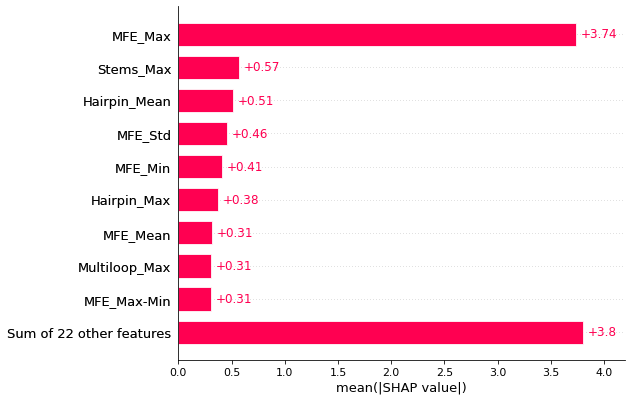

In [271]:
shap.plots.bar(shap_values)

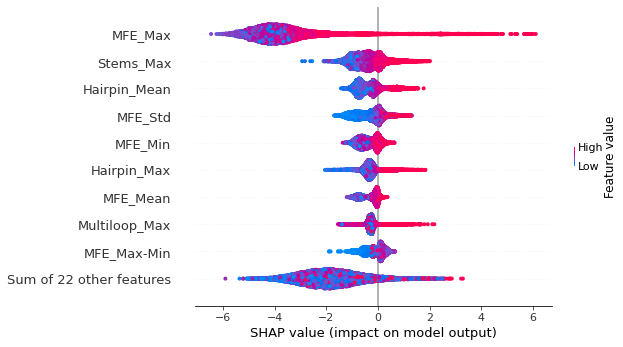

In [272]:
shap.plots.beeswarm(shap_values)

In [274]:
r = pd.read_csv('/tmp/data.txt', sep='\t')
r[r.rna != 'NoMatch']

,index,rna,family,length,label,sequence
49,49,HPnc0580,RF02269,154,3527,ACATTCGTATCTACGGCAGGAAGTGTCGGAAGTTACGCCTTTGGAG...
60,60,HPnc0580,RF02269,235,4215,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...
61,61,HPnc0580,RF02269,235,4220,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...
62,62,HPnc0580,RF02269,259,4221,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...
63,63,HPnc0580,RF02269,173,4222,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...
66,66,HPnc0580,RF02269,290,4296,AGAGTCTCCTTTTTTGGTATTTTTAAAACTCTTTGGCAGAAATCCC...
67,67,HPnc0580,RF02269,290,4297,AGAGTCTCCTTTTTTGGTATTTTTAAAACTCTTTGGCAGAAATCCC...
68,68,tRNA-Sec,RF01852,169,4339,AGATGACCTTTATAGTGGCGAGAGAGCCAAAGAATCGAACTTTGCA...
75,75,HPnc0580,RF02269,289,4522,AGCCTTATTAATATCTAATACAGCTGAAGCTTGGCTTTTAAAACTC...
102,102,HPnc0580,RF02269,385,5588,ATCCTGCGCGTTTAAAAATTCTATGGCTAAGGGAGTTAAACTGCCC...


In [277]:
labels = r[r.rna != 'NoMatch'].label.astype(int)

In [276]:
nfsset.iloc[r[r.rna != 'NoMatch'].label.astype(int)]

,seqs,rnatype,MFE_Max-Min,MFE_Mean,MFE_Std,MFE_Min,MFE_Max,MFE_Median,Hairpin_Max-Min,Hairpin_Mean,...,Stems_Min,Stems_Max,Stems_Median,Multiloop_Max-Min,Multiloop_Mean,Multiloop_Std,Multiloop_Min,Multiloop_Max,Multiloop_Median,nMFE
0,ACATTCGTATCTACGGCAGGAAGTGTCGGAAGTTACGCCTTTGGAG...,NFS,7.724137931034477,-67.57590685176892,1.7183203682572659,-71.93103448275862,-64.20689655172414,-67.17241379310344,0.006493506493506494,0.013197841119919042,...,0.045454545454545456,0.07792207792207792,0.05194805194805195,0.01948051948051948,0.00037949063923089897,0.0026923338658027614,0.0,0.01948051948051948,0.0,-67.054795
0,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...,NFS,4.955752212389385,-69.37751835812466,0.9043023214307501,-72.2566371681416,-67.30088495575221,-69.11504424778761,0.00851063829787234,0.020896333182435493,...,0.03829787234042553,0.059574468085106386,0.05106382978723404,0.02127659574468085,0.0029877772747849704,0.006324762044933628,0.0,0.02127659574468085,0.0,-69.118943
0,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...,NFS,4.9557522123893705,-67.88702692524949,0.9397447697280228,-70.79646017699115,-65.84070796460178,-67.65486725663717,0.01702127659574468,0.017818017202354007,...,0.0425531914893617,0.059574468085106386,0.05106382978723404,0.02127659574468085,0.0009597102761430511,0.0037350261203471995,0.0,0.02127659574468085,0.0,-67.665198
0,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...,NFS,4.480000000000004,-68.25250965250966,0.8428364244168722,-70.76,-66.28,-68.12,0.011583011583011582,0.015563274250532938,...,0.03861003861003861,0.06177606177606178,0.05791505791505792,0.03088803088803089,0.019006872288725572,0.0037356524310445693,0.0,0.03088803088803089,0.019305019305019305,-67.928287
0,AGACATTTGGGCTTCCTAGGCTGATGTTGCCCGTAGGGAGAGTTTG...,NFS,6.829268292682926,-68.97680812068236,1.3130756001119894,-72.86585365853658,-66.03658536585365,-68.65853658536585,0.005780346820809248,0.011961642554044574,...,0.03468208092485549,0.05202312138728324,0.046242774566473986,0.023121387283236993,0.01610478131578068,0.004875693744668507,0.0,0.023121387283236993,0.017341040462427744,-68.545455
0,AGAGTCTCCTTTTTTGGTATTTTTAAAACTCTTTGGCAGAAATCCC...,NFS,3.985765124555158,-64.61995336851147,0.8286034710674722,-66.76156583629893,-62.77580071174377,-64.34163701067615,0.010344827586206896,0.02061831153388823,...,0.04827586206896552,0.06896551724137931,0.06206896551724138,0.017241379310344827,0.017431629013079666,0.0014191228297584489,0.010344827586206896,0.027586206896551724,0.017241379310344827,-64.255319
0,AGAGTCTCCTTTTTTGGTATTTTTAAAACTCTTTGGCAGAAATCCC...,NFS,3.985765124555158,-62.82181862805252,0.8567933077842128,-64.91103202846975,-60.92526690391459,-62.50889679715303,0.010344827586206896,0.020582639714625445,...,0.04827586206896552,0.06896551724137931,0.06206896551724138,0.017241379310344827,0.017395957193816886,0.0013795665840957737,0.010344827586206896,0.027586206896551724,0.017241379310344827,-62.411348
0,AGATGACCTTTATAGTGGCGAGAGAGCCAAAGAATCGAACTTTGCA...,NFS,4.6875,-73.09948224852072,0.955955285858405,-75.3125,-70.625,-73.0,0.01775147928994083,0.02993592661321382,...,0.047337278106508875,0.07692307692307693,0.05325443786982249,0.05917159763313609,0.026679738104408112,0.013318854021042669,0.0,0.05917159763313609,0.01775147928994083,-73.167702
0,AGCCTTATTAATATCTAATACAGCTGAAGCTTGGCTTTTAAAACTC...,NFS,4.0,-66.54201680672269,0.808373223987933,-68.82142857142857,-64.82142857142857,-66.35714285714286,0.006920415224913495,0.019971025251134443,...,0.04844290657439446,0.0657439446366782,0.05536332179930796,0.020761245674740483,0.02503561978424588,0.004422055970364427,0.010380622837370242,0.031141868512110725,0.02768166089965398,-66.298932
0,ATCCTGCGCGTTTAAAAATTCTATGGCTAAGGGAGTTAAACTGCCC...,NFS,2.9787234042553195,-69.22651284885328,0.48525551092701547,-70.95744680851064,-67.97872340425532,-69.1223404255319,0.01038961038961039,0.018377466689155002,...,0.03896103896103896,0.05974025974025974,0.05454545454545454,0.023376623376623377,0.0304874346432788,0

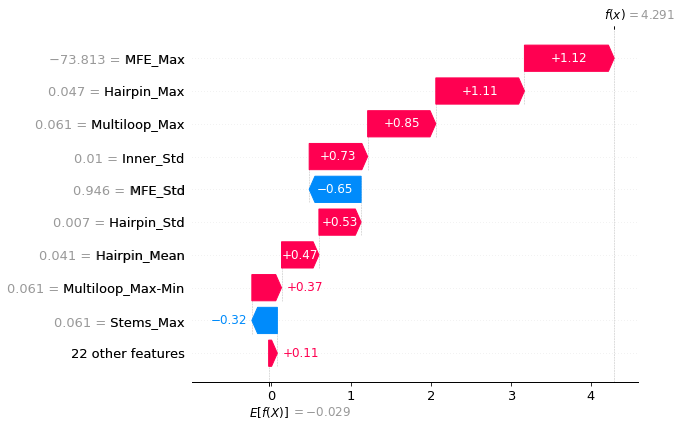

In [279]:
shap.plots.waterfall(shap_values[16058])

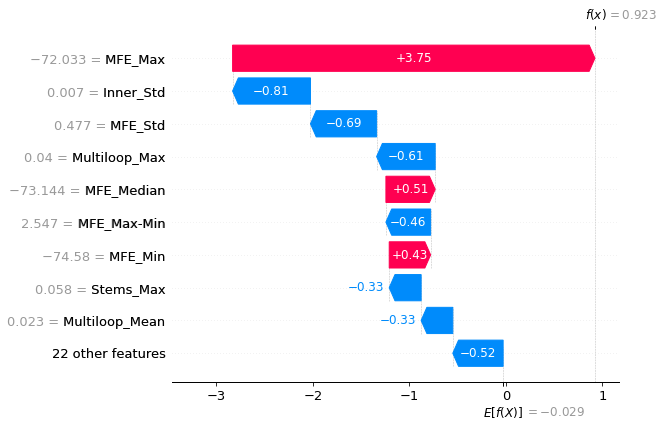

In [282]:
shap.plots.waterfall(shap_values[6713])

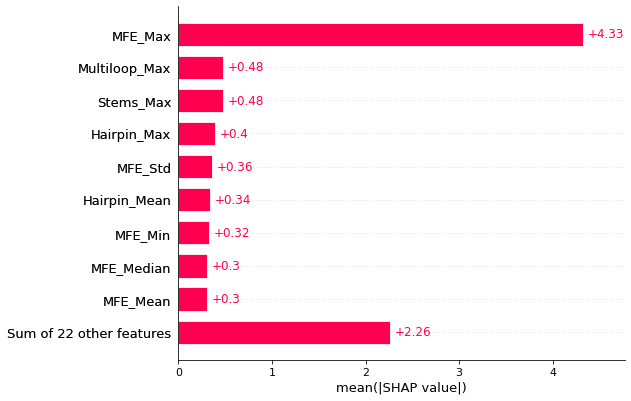

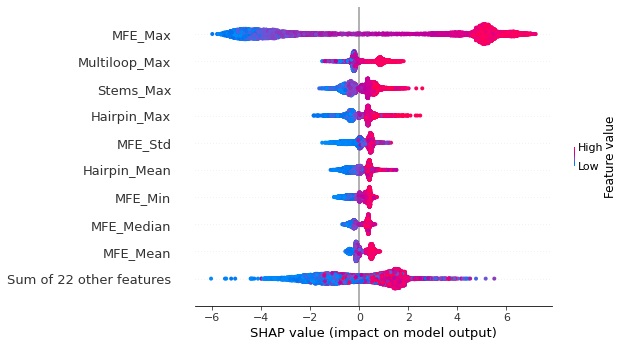

In [28]:
shap.initjs()

In [29]:
shap.plots.force(shap_values[26])